In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [25]:
#separate train and test train_test_split function' 
def train_test_split_local(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_test_split(y, shuffle=False)
    return X_train, X_test, y_train, y_test

def read(file_name, fheader, fuser, ftrial):
    fsadl1 = pd.read_csv(file_name, sep=' ', header=None)
    fdata = fsadl1.iloc[:, :243]
    fdata.columns = fheader
    fdata=fdata[fdata.columns[np.r_[0:45,50:58,63:71,76:84,89:97,102:133]]]
    flabels = fsadl1.iloc[:,243]
    ## Preprocessing data
    #find and remove rows with all nulls
    fidx=fdata.index[fdata.isnull().all(1)] #1 is the axis for rows
    #select data not in idx, that is data that is not all null
    fdata = fdata[~fdata.index.isin(fidx)] 
    #same for labels
    flabels = flabels[~flabels.index.isin(fidx)]

    #see how many there are of each label
    #what does it mean ?
    flabels.value_counts()


    #fill missing values
    fdata = fdata.fillna(method='ffill',axis=1)


    fdata['user'] = fuser
    fdata['trial'] = ftrial
    return fdata, flabels
    
def windowing(fdata, window_number, window_text, porcentage, flabels, frol):
    ffiltered_data = fdata[columns].rolling(frol).median()
    ffiltered_data['MILLISEC'] = fdata.MILLISEC


    # Windowing and Feature Extraction
    ffiltered_data['time']=pd.to_datetime(fdata.MILLISEC,unit='ms')
    ffiltered_data.index=ffiltered_data.time
    #calculate mean over a 1 second window
    keep = ffiltered_data.time.dt.microsecond/window_number %porcentage
    keep = keep - keep.shift() < 0

    means = ffiltered_data[columns].rolling(window_text).mean()[keep]
    means.columns = [str(col) + '_mean' for col in means.columns]
    variances = ffiltered_data[columns].rolling(window_text).var()[keep]
    variances.columns = [str(col) + '_var' for col in variances.columns]

    #talk about apply function
    flabels.index = ffiltered_data.time
    mode_labels = flabels.rolling(window_text).apply(lambda x:mode(x)[0])[keep]

    #all features
    fall_features = pd.concat([means, variances],axis=1)
    fall_features['label'] = mode_labels
    fall_features['user'] = user
    fall_features['trial'] = trial
    
    return fall_features

def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')


def excercise_1 (fall_data):
    # Excercise 1
    # Random train test split

    # Labels are the values we want to predict
    labels = np.array(fall_data['label'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = fall_data.drop('label', axis = 1)
    features = features.drop('user', axis = 1)
    features = features.drop('trial', axis = 1)


    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)


    X_train, X_test, y_train, y_test = train_test_split_local(features, labels)

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)


    classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test)


    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("accuracy score: \n")  
    print(accuracy_score(y_test, y_pred))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), labels)

def excercise_2 (fall_data):
    # Excercise 2
    # user 1 2 3 train test 4

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    user123 = fall_data[fall_data['user'].isin([1, 2, 3])]
    user4 = fall_data[fall_data['user'].isin([4])]


    y_train_2 = np.array(user123['label'])
    y_test_2 = np.array(user4['label'])

    user123 = user123.drop('label', axis = 1)
    user123 = user123.drop('user', axis = 1)
    user123 = user123.drop('trial', axis = 1)

    user4 = user4.drop('label', axis = 1)
    user4 = user4.drop('user', axis = 1)
    user4 = user4.drop('trial', axis = 1)

    X_train_2 = np.array(user123)
    X_test_2 = np.array(user4)
    print('X_train_2:', X_train_2.shape)
    print('X_test_2:', X_test_2.shape)
    print('y_train_2:', y_train_2.shape)
    print('y_test_2:', y_test_2.shape)


    classifier2 = RandomForestClassifier(n_estimators=20, random_state=0)  
    classifier2.fit(X_train_2, y_train_2)  
    y_pred_2 = classifier2.predict(X_test_2)

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_2,y_pred_2))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_2,y_pred_2))  
    print("\n _______________________________________________________")  
    print("accuracy score: \n")  
    print(accuracy_score(y_test_2, y_pred_2))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_2,y_pred_2), labels)

def excercise_3 (fall_data):  
    # Excercise 3
    #  1,2,3 and drill session as training data and trials 4 and 5 as test data.

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    trial1236 = fall_data[fall_data['trial'].isin([1, 2, 3, 6])]
    trial45 = fall_data[fall_data['trial'].isin([4, 5])]

    y_train_3 = np.array(trial1236['label'])
    y_test_3 = np.array(trial45['label'])

    trial1236 = trial1236.drop('label', axis = 1)
    trial1236 = trial1236.drop('user', axis = 1)
    trial1236 = trial1236.drop('trial', axis = 1)

    trial45 = trial45.drop('label', axis = 1)
    trial45 = trial45.drop('user', axis = 1)
    trial45 = trial45.drop('trial', axis = 1)

    X_train_3 = np.array(trial1236)
    X_test_3 = np.array(trial45)

    print('X_train_3:', X_train_3.shape)
    print('X_test_3:', X_test_3.shape)
    print('y_train_3:', y_train_3.shape)
    print('y_test_3:', y_test_3.shape)


    classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
    classifier.fit(X_train_3, y_train_3)  
    y_pred_3 = classifier.predict(X_test_3)


    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_3,y_pred_3))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_3,y_pred_3))  
    print("\n _______________________________________________________")  
    print("accuracy score: \n")  
    print(accuracy_score(y_test_3, y_pred_3))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_3,y_pred_3), labels)

In [3]:
#Read data
path = 'dataset/' #enter thepath for the dataset folder
header_path = 'header.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''])['column'].values
users = range(1,5)
trials = range(1,7)
all_data_1S = pd.DataFrame()
all_data_2S = pd.DataFrame()
all_data_5S = pd.DataFrame()
all_data_10S = pd.DataFrame()

In [4]:

for user in users:
    for trial in trials:
        if trial == 6:
            file_name = path+'S'+str(user)+'-Drill'+'.dat'
        else:
            file_name = path+'S'+str(user)+'-ADL'+str(trial)+'.dat'
        data, labels = read(file_name, header, user, trial)
        columns = data.columns[~data.columns.isin(['user', 'trial','MILLISEC'])]
        #we use a window of 11 elements
        # Filtering using median filter
        
        all_features_1S = windowing(data, 1000, '1S', 500, labels, 11)
        all_data_1S = pd.concat([all_data_1S, all_features_1S])
        
        all_features_2S = windowing(data, 2000, '2S', 1000, labels, 11)
        all_data_2S = pd.concat([all_data_2S, all_features_2S])
        
        all_features_5S = windowing(data, 5000, '5S', 2500, labels, 11)
        all_data_5S = pd.concat([all_data_5S, all_features_5S])
        
        all_features_10S = windowing(data, 10000, '10S', 5000, labels, 11)
        all_data_10S = pd.concat([all_data_10S, all_features_10S])

    

In [5]:
data.describe()

,MILLISEC,Accelerometer_RKN^_accX,Accelerometer_RKN^_accY,Accelerometer_RKN^_accZ,Accelerometer_HIP_accX,Accelerometer_HIP_accY,Accelerometer_HIP_accZ,Accelerometer_LUA^_accX,Accelerometer_LUA^_accY,Accelerometer_LUA^_accZ,...,InertialMeasurementUnit_R-SHOE_Body_Ay,InertialMeasurementUnit_R-SHOE_Body_Az,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameX,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameY,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameZ,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameX,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameY,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameZ,user,trial
count,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,...,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.0,45460.0
mean,7.576424e+05,7.205346e+04,7.273918e+04,7.213026e+04,7.473093e+03,8.570559e+03,7.912822e+03,5.460099e+03,5.830548e+03,5.107764e+03,...,527.461615,751.195139,15.213308,72.193445,46.187593,72.193445,-12.695095,46.187593,4.0,6.0
std,4.374395e+05,2.770680e+05,2.768902e+05,2.770482e+05,9.730875e+04,9.722217e+04,9.727437e+04,8.701798e+04,8.699683e+04,8.703878e+04,...,463.129698,421.830454,1651.352297,1028.671603,915.979974,1028.671603,1651.373576,915.979974,0.0,0.0
min,0.000000e+00,-2.240000e+03,-7.560000e+02,-1.907000e+03,-1.002000e+03,-5.700000e+01,-1.456000e+03,-2.500000e+02,-7.990000e+02,-1.076000e+03,...,-4985.000000,-5305.000000,-8661.000000,-13377.000000,-15677.000000,-13377.000000,-13458.000000,-15677.000000,4.0,6.0
25%,3.788215e+05,1.110000e+02,9.100000e+02,6.500000e+01,-3.380000e+02,8.510000e+02,1.390000e+02,3.220000e+02,7.490000e+02,-6.000000e+01,...,390.000000,694.000000,-43.000000,-42.000000,-44.000000,-42.000000,-75.000000,-44.000000,4.0,6.0
50%,7.576425e+05,2.090000e+02,1.010000e+03,2.510000e+02,-1.290000e+02,9.180000e+02,3.390000e+02,4.035000e+02,8.620000e+02,1.630000e+02,...,407.000000,799.000000,3.000000,3.000000,-3.000000,3.000000,-3.000000,-3.000000,4.0,6.0
75%,1.136464e+06,3.680000e+02,1.048000e+03,5.560000e+02,-4.800000e+01,9.710000e+02,4.580000e+02,5.570000e+02,9.380000e+02,2.830000e+02,...,547.000000,809.000000,77.000000,77.000000,46.000000,77.000000,44.000000,46.000000,4.0,6.0
max,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,...,7100.000000,5496.000000,13458.000000,9670.000000,6765.000000,9670.000000,8661.000000,6765.000000,4.0,6.0


In [6]:
data

,MILLISEC,Accelerometer_RKN^_accX,Accelerometer_RKN^_accY,Accelerometer_RKN^_accZ,Accelerometer_HIP_accX,Accelerometer_HIP_accY,Accelerometer_HIP_accZ,Accelerometer_LUA^_accX,Accelerometer_LUA^_accY,Accelerometer_LUA^_accZ,...,InertialMeasurementUnit_R-SHOE_Body_Ay,InertialMeasurementUnit_R-SHOE_Body_Az,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameX,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameY,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameZ,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameX,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameY,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameZ,user,trial
0,0.0,80.0,1044.0,103.0,-41.0,969.0,358.0,367.0,915.0,240.0,...,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,4,6
1,33.0,80.0,1031.0,125.0,-49.0,990.0,328.0,342.0,934.0,243.0,...,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,4,6
2,67.0,79.0,1038.0,129.0,-57.0,970.0,346.0,348.0,925.0,247.0,...,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,4,6
3,100.0,95.0,1034.0,129.0,-45.0,963.0,345.0,357.0,940.0,229.0,...,626.0,626.0,626.0,626.0,626.0,626.0,626.0,626.0,4,6
4,133.0,102.0,1021.0,121.0,-37.0,976.0,361.0,364.0,919.0,235.0,...,624.0,624.0,624.0,624.0,624.0,624.0,624.0,624.0,4,6
5,167.0,81.0,1038.0,101.0,-40.0,966.0,346.0,352.0,913.0,254.0,...,624.0,624.0,624.0,624.0,624.0,624.0,624.0,624.0,4,6
6,200.0,80.0,1069.0,99.0,-29.0,976.0,354.0,367.0,939.0,232.0,...,626.0,626.0,626.0,626.0,626.0,626.0,626.0,626.0,4,6
7,233.0,80.0,1040.0,119.0,-39.0,966.0,344.0,372.0,924.0,203.0,...,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,4,6
8,267.0,78.0,1034.0,107.0,-49.0,975.0,374.0,361.0,920.0,242.0,...,625.0,625.0,625.0,625.0,625.0,625.0,625.0,625.0,4,6
9,300.0,61.0,1047.0,100.0,-37.0,954.0,354.0,361.0,930.0,234.0,...,626.0,626.0,626.0,626.0,626.0,626.0,626.0,626.0,4,6


In [7]:
print("\n _______________________________________________________")  
print(all_data_1S.head())
print("\n _______________________________________________________")  
print(all_data_2S.head())
print("\n _______________________________________________________")  
print(all_data_5S.head())
print("\n _______________________________________________________")  
print(all_data_10S.head())


 _______________________________________________________
                         Accelerometer_RKN^_accX_mean  \
time                                                    
1970-01-01 00:00:00.500                    105.000000   
1970-01-01 00:00:01.000                     47.761905   
1970-01-01 00:00:01.500                    -31.733333   
1970-01-01 00:00:02.000                    -83.633333   
1970-01-01 00:00:02.500                    -15.100000   

                         Accelerometer_RKN^_accY_mean  \
time                                                    
1970-01-01 00:00:00.500                    961.666667   
1970-01-01 00:00:01.000                    975.000000   
1970-01-01 00:00:01.500                    989.700000   
1970-01-01 00:00:02.000                    992.066667   
1970-01-01 00:00:02.500                    991.933333   

                         Accelerometer_RKN^_accZ_mean  \
time                                                    
1970-01-01 00:00:00.500     

In [8]:
print("\n _______________________________________________________")  
print(all_data_1S.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S.label.value_counts())


 _______________________________________________________
1.0    23172
2.0    13218
0.0    10747
4.0     9119
5.0     1692
Name: label, dtype: int64

 _______________________________________________________
1.0    11558
2.0     6633
0.0     5368
4.0     4565
5.0      844
Name: label, dtype: int64

 _______________________________________________________
1.0    11796
2.0     6378
0.0     5326
4.0     4607
5.0      861
Name: label, dtype: int64

 _______________________________________________________
1.0    12483
2.0     5500
0.0     5354
4.0     4703
5.0      928
Name: label, dtype: int64


In [9]:
print("\n _______________________________________________________")  
print(all_data_1S.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S.trial.value_counts())


 _______________________________________________________
6    14981
1    11513
3     7956
5     7930
2     7863
4     7705
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64


In [10]:
print("\n _______________________________________________________")  
print(all_data_1S.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S.user.value_counts())


 _______________________________________________________
1    15641
2    15010
3    14455
4    12842
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64


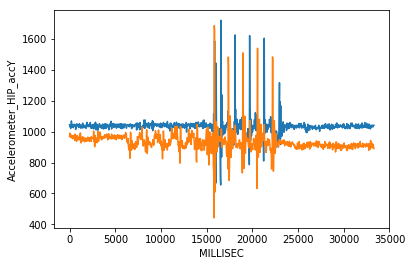

In [11]:
#Plot explore other features
sns.lineplot(x='MILLISEC',y='Accelerometer_RKN^_accY', data=data[:1000])
sns.lineplot(x='MILLISEC',y='Accelerometer_HIP_accY', data=data[:1000])

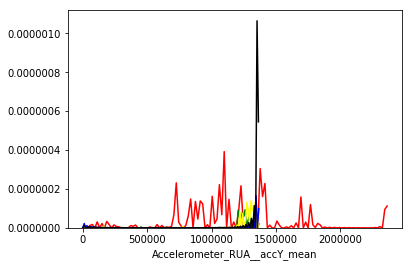

In [12]:
#separate by class, see feature mean
all_data_1S_0 = all_data_1S[all_data_1S.label==0]
all_data_1S_1 = all_data_1S[all_data_1S.label==1]
all_data_1S_2 = all_data_1S[all_data_1S.label==2]
all_data_1S_4 = all_data_1S[all_data_1S.label==4]
all_data_1S_5 = all_data_1S[all_data_1S.label==5]

draw_col = 10
sns.distplot(all_data_1S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_1S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_1S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_1S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_1S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

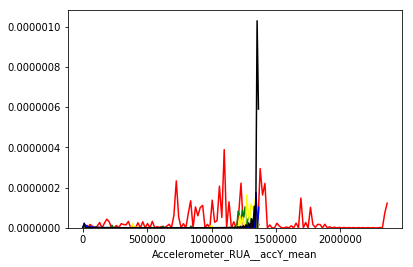

In [13]:
#separate by class, see feature mean
all_data_2S_0 = all_data_2S[all_data_2S.label==0]
all_data_2S_1 = all_data_2S[all_data_2S.label==1]
all_data_2S_2 = all_data_2S[all_data_2S.label==2]
all_data_2S_4 = all_data_2S[all_data_2S.label==4]
all_data_2S_5 = all_data_2S[all_data_2S.label==5]

draw_col = 10
sns.distplot(all_data_2S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_2S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_2S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_2S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_2S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

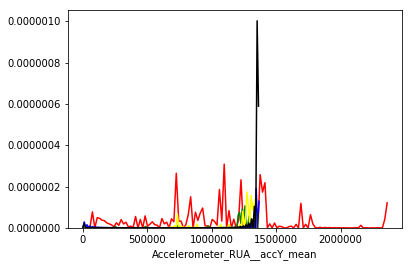

In [14]:
#separate by class, see feature mean
all_data_5S_0 = all_data_5S[all_data_5S.label==0]
all_data_5S_1 = all_data_5S[all_data_5S.label==1]
all_data_5S_2 = all_data_5S[all_data_5S.label==2]
all_data_5S_4 = all_data_5S[all_data_5S.label==4]
all_data_5S_5 = all_data_5S[all_data_5S.label==5]

draw_col = 10
sns.distplot(all_data_5S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_5S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_5S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_5S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_5S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

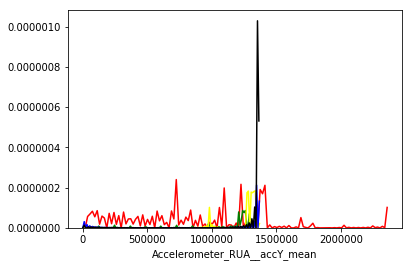

In [15]:
#separate by class, see feature mean
all_data_10S_0 = all_data_10S[all_data_10S.label==0]
all_data_10S_1 = all_data_10S[all_data_10S.label==1]
all_data_10S_2 = all_data_10S[all_data_10S.label==2]
all_data_10S_4 = all_data_10S[all_data_10S.label==4]
all_data_10S_5 = all_data_10S[all_data_10S.label==5]

draw_col = 10
sns.distplot(all_data_10S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_10S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_10S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_10S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_10S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

#############################
X_train: (38825, 214)
X_test: (19123, 214)
y_train: (38825,)
y_test: (19123,)

 _______________________________________________________
confusion matrix: 

[[3169  176  171   19    6]
 [  29 7166  410    7    0]
 [  62  742 3633    4    0]
 [  13   77   17 2842    4]
 [   9    1    1    6  559]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      3541
         1.0       0.88      0.94      0.91      7612
         2.0       0.86      0.82      0.84      4441
         4.0       0.99      0.96      0.97      2953
         5.0       0.98      0.97      0.98       576

   micro avg       0.91      0.91      0.91     19123
   macro avg       0.93      0.92      0.93     19123
weighted avg       0.91      0.91      0.91     19123


 _______________________________________________________
accuracy score: 

0.9082779898551483
######

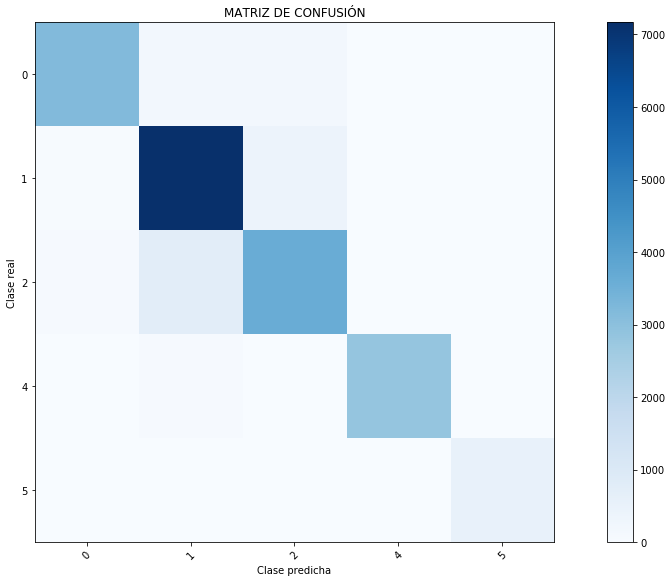

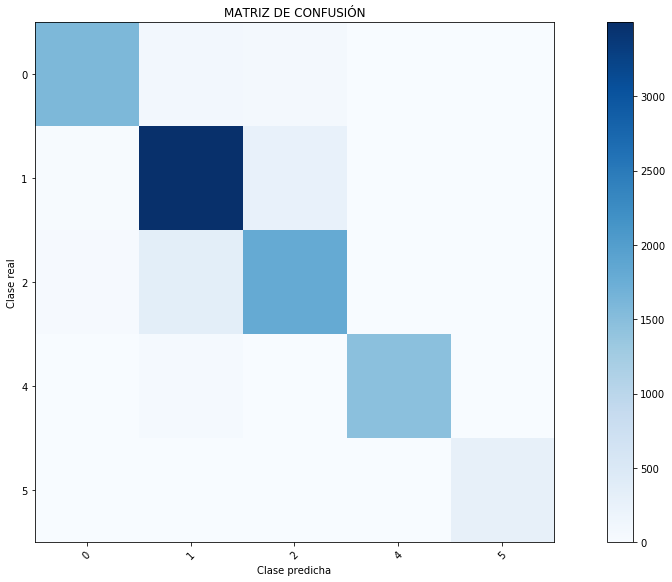

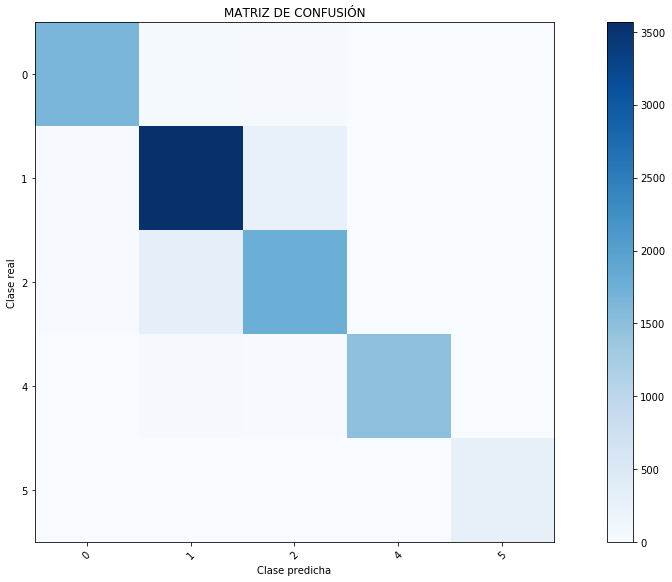

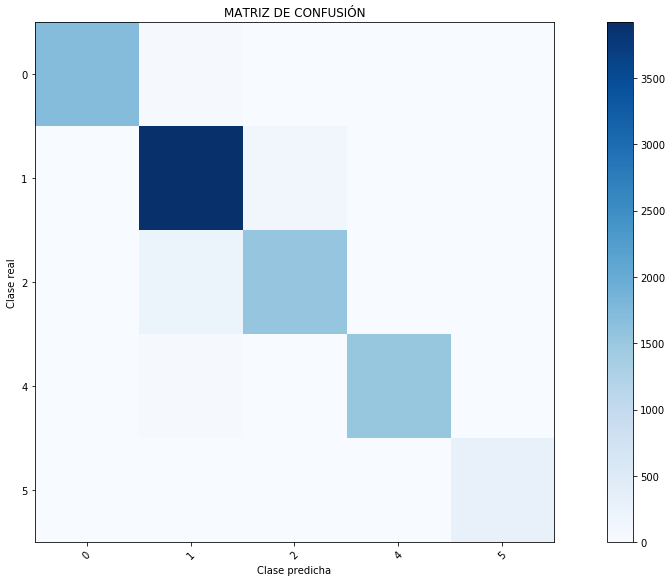

In [21]:
print("#############################")
excercise_1(all_data_1S)
print("#############################")
excercise_1(all_data_2S)
print("#############################")
excercise_1(all_data_5S)
print("#############################")
excercise_1(all_data_10S)
print("#############################")

#############################
X_train_2: (45106, 214)
X_test_2: (12842, 214)
y_train_2: (45106,)
y_test_2: (12842,)

 _______________________________________________________
confusion matrix: 

[[1950  796  277   13    0]
 [ 102 4411  590   16    0]
 [  58  367 2325    3    0]
 [  70  115   41 1355    0]
 [ 116    6    4   35  192]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.85      0.64      0.73      3036
         1.0       0.77      0.86      0.82      5119
         2.0       0.72      0.84      0.78      2753
         4.0       0.95      0.86      0.90      1581
         5.0       1.00      0.54      0.70       353

   micro avg       0.80      0.80      0.80     12842
   macro avg       0.86      0.75      0.79     12842
weighted avg       0.81      0.80      0.79     12842


 _______________________________________________________
accuracy score: 

0.796838498676218

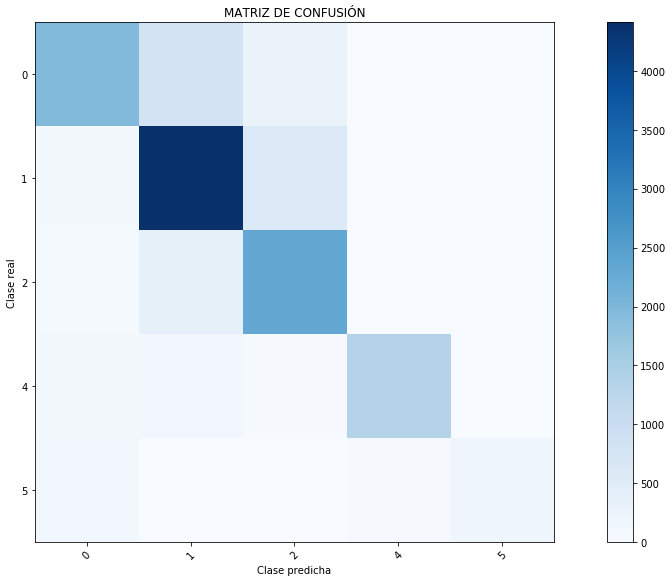

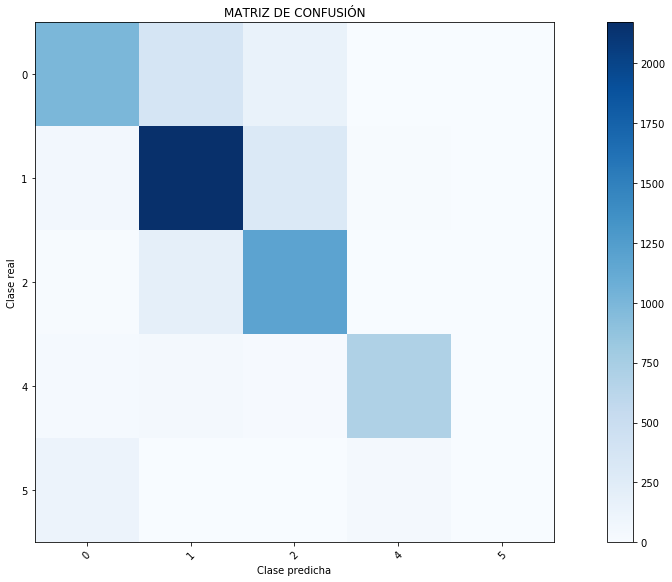

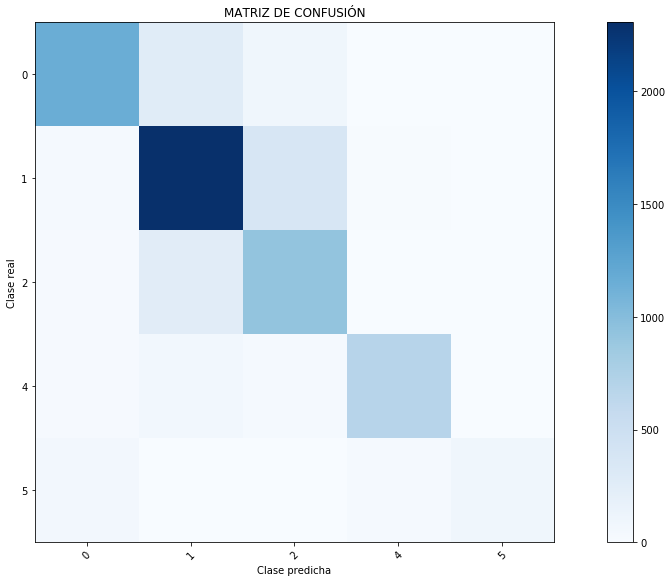

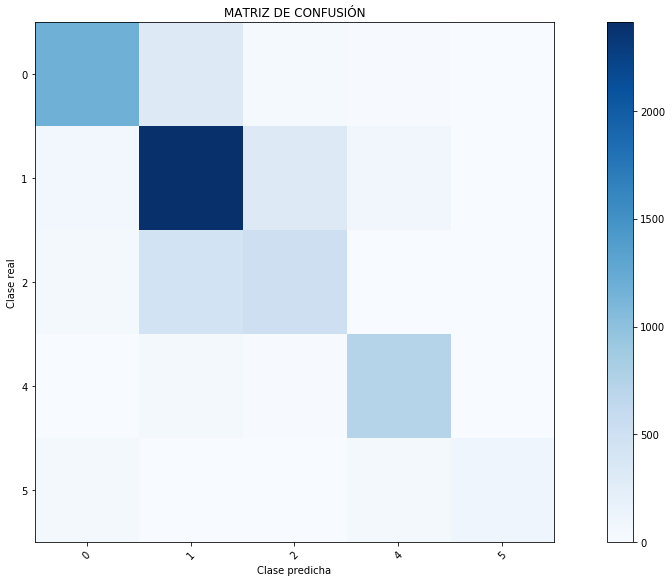

In [26]:
print("#############################")
excercise_2(all_data_1S)
print("#############################")
excercise_2(all_data_2S)
print("#############################")
excercise_2(all_data_5S)
print("#############################")
excercise_2(all_data_10S)
print("#############################")



In [ ]:
print("#############################")
excercise_3(all_data_1S)
print("#############################")
excercise_3(all_data_2S)
print("#############################")
excercise_3(all_data_5S)
print("#############################")
excercise_3(all_data_10S)
print("#############################")



#############################
X_train_3: (42313, 214)
X_test_3: (15635, 214)
y_train_3: (42313,)
y_test_3: (15635,)

 _______________________________________________________
confusion matrix: 

[[2750  419  341   70   17]
 [  94 4629  264    3    0]
 [ 145  514 2847    0    0]
 [  13   40   13 2842    1]
 [   9    3    1    8  612]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      3597
         1.0       0.83      0.93      0.87      4990
         2.0       0.82      0.81      0.82      3506
         4.0       0.97      0.98      0.97      2909
         5.0       0.97      0.97      0.97       633

   micro avg       0.87      0.87      0.87     15635
   macro avg       0.90      0.89      0.89     15635
weighted avg       0.88      0.87      0.87     15635


 _______________________________________________________
accuracy score: 

0.874960025583626